In [1]:
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_url = 'https://drive.google.com/uc?export=download&id=1SYAbRXOY96UqmOVLVqzG6J1koozpDQ29'

train = pa.read_csv(train_url)

# Image Recognition

This dataset is a collection of images of hand drawn digits. The task being set is to develop a method for a computer to read the image and identify what number it is. The way we will try to do this is that we have divided our data into a training set and a testing set. We will use the training set to develop the algorithm and then the testing set to test how well we did.

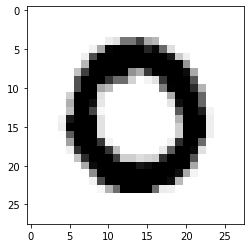

In [5]:
plt.imshow(np.array(train.iloc[1, 1:]).reshape(28, 28), cmap='binary')

### Applications

This dataset is a classic example and was one of the first image centered machine learning problems, it was posed initially by the US Postal Service when they were developing their high speed automated sorting systems - they wanted a method of reading handwritten zip codes.  Colleagues of mine at the University of British Columbia used this testing and training set to develop an algorithm for reading student id numbers on exams for an online grading system they built.

Note that accuracy is very important in these applications. An error rate of 0.01 on reading digits means that if we scan the five digits of a zip code the error rate on the zip code (the probability that at least one digit is wrong) is:

In [6]:
1 - 0.99**5

0.04900995010000009

If you starting using it for student id numbers or longer numbers the situation is even worse.

## Images as Data in the Sense of Probability and Statistics

An interesting question is how do we think of images as Data in the sens of our MATH 351 class. Each image is a collection of intensity values for each pixel in the rectangle identifying how bright or dark that pixel should be. These images are 30x30 and so each one has $30^2 = 900 $ values associated with it.  We think of each image as a member of our sample and then the values for its pixes as the associated random variables. 

Immediately you see the fundamental difference between this problem and the ones in our class we have been doing. There is a lot more data for each member of the sample than we typically considered.

You also see though that for example, we expect a high degree of correlation:  A pixel that is dark black is very likely to have neighbors that are dark black or at least not white.

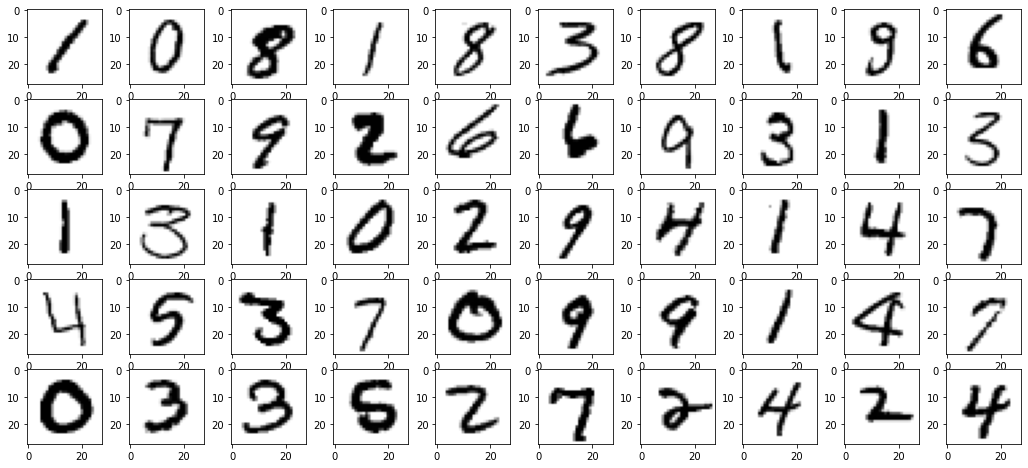

In [7]:
fig, ax = plt.subplots(5, 10, figsize = (18, 8))

for i in range(50):
    ax[i%5][i//5].imshow( np.array(train.iloc[i, 1:]).reshape(28, 28), cmap = 'binary' )

## Principal Component Analysis

Because the size of the problem is so big, one needs some techniques for reducing the problem to the most important parts. One tool for doing this is **Principal Component Analsysis** which is a variation (or at least similar) to the eigenvalue decomposition you learned about in linear algebra. It determines which linear combinations of the pixels do the most to explain the variations in the values for the pixels. I.e. it tries to weed through the correlations and leave us with just the most explanatory values.

In [8]:
from sklearn.decomposition import PCA

In [9]:
# First we separate out the pixel values from the known value of the image:  
# we are thinking now of the image X as the input and y as the output.

X = np.array(train.iloc[:, 1:])
y = np.array(train.iloc[:, 0])

In [10]:
xpca = PCA().fit(X)
XPCA = xpca.transform(X)

Here we will plot the first two principal components with one digit colored in blue and the others in red, that is theses are the two most descriptive features identified by the linear algebra computation done by the PCA algorithm. We note that for some of the digits notably 0, 1, 2, 3, and 4 it definitely appears that the first two components do separate them from the other digits. 

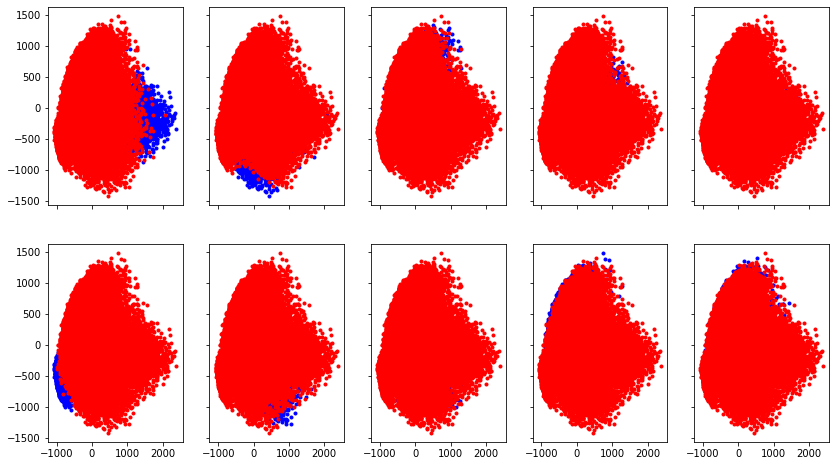

In [11]:
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize = (14, 8))

for i in range(10):
    ax[i%2, i//2].plot(XPCA[y==i,0],XPCA[y==i,1],'b.')   
    ax[i%2, i//2].plot(XPCA[y!=i,0],XPCA[y!=i,1],'r.')

Another excersise that illustrates what we have accomplished is to actually render the principal components as images:

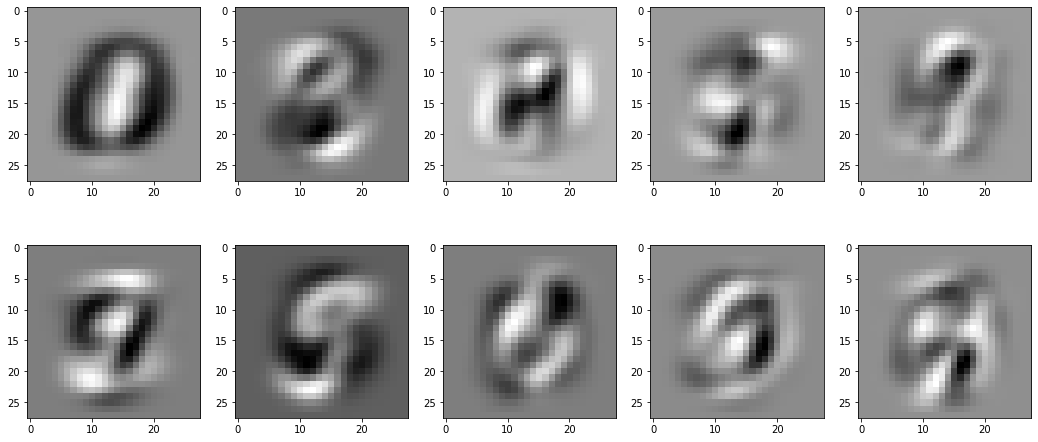

In [12]:
x = xpca.components_
v = []
for i in range(10):
    v = v + [x[i].reshape(28, 28)]
    
fig, ax = plt.subplots(2, 5, figsize = (18, 8))

for i in range(10):
    ax[i%2][i//2].imshow(v[i], cmap='binary')

Notice the languages connecting our class to this work:  Here we show that as we add the principle components in order we explain more and more of the variance in the data. The principal components are ordered and the first few explain much more of the variance than the later ones.

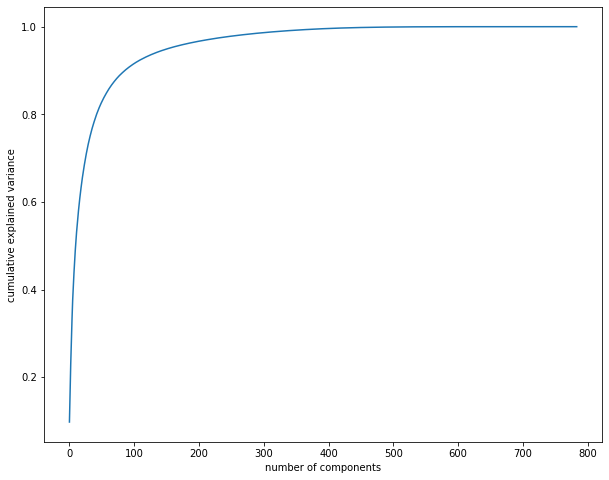

In [13]:
plt.figure( figsize = (10, 8))
plt.plot(np.cumsum(xpca.explained_variance_ratio_) )
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Machine Learning

So now the game is to develop tests that look at the data for an image and make a prediction about what number that image represents. They will do this by first computing the Principal Components for that image and then using those to make a prediction. We can speed this up by only using some of the principle components knowing that the first few of them go a long way to accounting for the variances in the images.

The model we will use is called a *Neural Network* it is built out of cells that take the values for each principle component from our image and then combine them in cells; these cells then pass information to the next layer of cells, and so on until the final layer of cells produces an output of 0, 1, 2, ..., 9 and that is our prediction. We train the network by deciding how strong each connection from cell to cell is so that the algorithm does as good as it can on the training data, and then the test is how well it does with the testing data.

What we actually do is repeat this testing and training process over and over.

In [14]:
import seaborn as sns
from sklearn.neural_network import MLPClassifier

def runTest(clf, X, y, training=0.66, plotTest=True, pad=0.1):
    
    # Make a training and testing set for the method
    perm = np.random.permutation(len(y))
    n = X.shape[0]
    trainSize = int(training*n)
    Xtrain = X[perm[:trainSize], :]   # Use all of the columns passed
    Xtest = X[perm[trainSize:], :]
    
    ytrain = y[perm[:trainSize]]
    ytest = y[perm[trainSize:]]
    
    # Run the calculation
    clf.fit(Xtrain, ytrain)
      
    # Print out some metrics
    print('Training Score: {}'.format(clf.score(Xtrain, ytrain)))
    print('Testing Score: {}'.format(clf.score(Xtest, ytest)))
    
    for i in range(10):
        print('Missed {}:  {}'.format(i, sum(clf.predict(Xtest[ytest!=i])==i)/sum(ytest!=i)))
    
    
    # Returning the training and testing scores
       
    return clf.score(Xtrain, ytrain), clf.score(Xtest, ytest)

In [17]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=[100])

runTest(mlp, XPCA[:, 0:100], y);

Training Score: 1.0
Testing Score: 0.9548319327731093
Missed 0:  0.003645954541928477
Missed 1:  0.0020594059405940595
Missed 2:  0.0050579721422457395
Missed 3:  0.005944931163954944
Missed 4:  0.00581170089112747
Missed 5:  0.005764353239566521
Missed 6:  0.003497862417411582
Missed 7:  0.005003909304143862
Missed 8:  0.005955603681645912
Missed 9:  0.007382080969772321


We can use what is call a confusion matrix to ask where the errors occur on the testing set:

<Figure size 432x288 with 0 Axes>

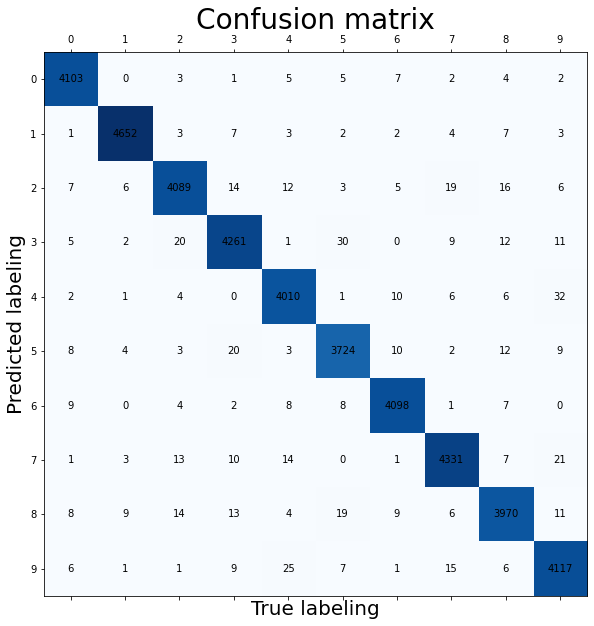

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = mlp.predict(XPCA[:, :100])
y_true = y
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# plt.imshow(cm, cmap = 'ocean')
# plt.colorbar

min_val, max_val = 0, 15

# intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
plt.figure(11)
fig, ax = plt.subplots(figsize = (10, 10))
ax.matshow(cm, cmap=plt.cm.Blues)
# ax.matshow(cm, cmap=plt.cm.magma_r)

for i in range(10):
    for j in range(10):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


plt.xticks(range(10))
plt.yticks(range(10))
plt.title('Confusion matrix',size = 28)
plt.xlabel('True labeling',size = 20)
plt.ylabel('Predicted labeling',size = 20)
plt.rcParams.update({'font.size': 22})